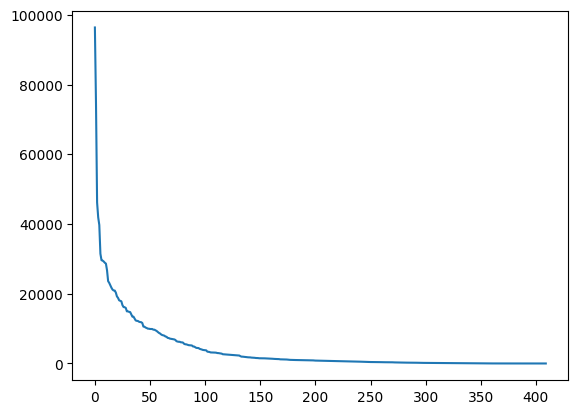

In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt

# Read in data
df = pd.read_csv("English_Cn_Name_Corpus（48W）.txt", header=None, names=["name"], skiprows=2)
names = df["name"].values

# Compute character frequency
chars = [list(name) for name in names]
chars_flatten = list(itertools.chain(*chars))
freq = collections.Counter(chars_flatten)
freq = pd.DataFrame(freq.items(), columns=["char", "freq"])
freq = freq.sort_values(by="freq", ascending=False)

# Frequency distribution
char_rank = np.arange(freq.shape[0])
char_freq = freq["freq"].values
plt.plot(char_rank, char_freq)

In [2]:
# Prepare data
dict_size = 50
charset_size = dict_size + 1  # for EOS
dict = list(freq["char"].values[:dict_size])
dict_set = set(dict)
dat = list(filter(lambda name: set(name).issubset(dict_set), names))

# One-hot encoding
def char2index(char):
    return dict.index(char)

def name2index(name):
    return [char2index(char) for char in name]

def char2tensor(char):
    tensor = torch.zeros(1, charset_size)
    tensor[0, char2index(char)] = 1
    return tensor

def name2tensor(name):
    tensor = torch.zeros(len(name), 1, charset_size)
    for i, char in enumerate(name):
        tensor[i, 0, char2index(char)] = 1
    return tensor

def names2tensor(names):
    n = len(names)
    lens = [len(name) for name in names]
    max_len = np.max(lens)
    tensor = torch.zeros(max_len, n, charset_size)
    target = torch.zeros(max_len, n, dtype=int) + charset_size - 1  # 开始全都是50，代表停止符
    for i in range(n):
        name = names[i]             # the i-th name
        for j in range(len(name)):  # the j-th character in the name
            tensor[j, i, char2index(name[j])] = 1
            if j < len(name) - 1:
                target[j, i] = char2index(name[j + 1])
    return tensor, np.array(lens), target

char2index("斯")

1

In [3]:
name2index("斯基")

[1, 17]

In [4]:
char2tensor("斯")

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
name2tensor("斯基")

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [6]:
names2tensor(["斯基", "斯诺夫"])

(tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0.,

In [7]:
# Build model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, input_size)
        self.o2o = nn.Linear(hidden_size + input_size, input_size)
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = torch.relu(self.i2h(input_combined))
        output = torch.relu(self.i2o(input_combined))
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.logsoftmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [8]:
n_hidden = 64
rnn = RNN(charset_size, n_hidden)
input = name2tensor("斯基")
hidden = rnn.init_hidden(batch_size=1)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-3.8769, -3.8379, -4.0937, -3.9832, -4.0277, -3.9607, -3.9372, -3.8446,
         -4.0200, -3.9447, -4.0265, -3.9387, -3.9561, -4.0500, -3.8296, -4.0310,
         -3.8942, -3.9387, -3.9640, -3.9387, -3.9396, -3.8499, -3.8135, -3.9969,
         -4.0112, -3.9483, -3.8273, -3.9290, -4.0002, -3.9387, -4.0159, -4.0057,
         -3.9382, -3.8956, -3.8394, -3.7901, -3.9827, -3.9032, -4.0231, -3.9341,
         -3.8340, -3.8574, -3.9309, -3.9740, -3.9267, -3.8872, -3.8140, -3.9586,
         -3.8816, -3.9624, -3.9456]], grad_fn=<LogSoftmaxBackward0>)

epoch 0, batch 0, loss = 3.9328794479370117
epoch 0, batch 10, loss = 3.537919521331787
epoch 0, batch 20, loss = 3.2228903770446777
epoch 0, batch 30, loss = 3.178758144378662
epoch 0, batch 40, loss = 3.1477208137512207
epoch 0, batch 50, loss = 3.123739719390869
epoch 0, batch 60, loss = 3.138552188873291
epoch 0, batch 70, loss = 3.149634599685669
epoch 0, batch 80, loss = 3.1343209743499756
epoch 0, batch 90, loss = 3.101452350616455
epoch 0, batch 100, loss = 3.0893895626068115
epoch 0, batch 110, loss = 3.0961766242980957
epoch 0, batch 120, loss = 3.074568748474121
epoch 0, batch 130, loss = 3.009594202041626
epoch 0, batch 140, loss = 3.0292439460754395
epoch 0, batch 150, loss = 3.004626512527466
epoch 0, batch 160, loss = 3.0277841091156006
epoch 0, batch 170, loss = 3.005244016647339
epoch 0, batch 180, loss = 2.9814088344573975
epoch 0, batch 190, loss = 2.9858202934265137
epoch 0, batch 200, loss = 2.9349331855773926
epoch 0, batch 210, loss = 2.9363608360290527
epoch 0, 

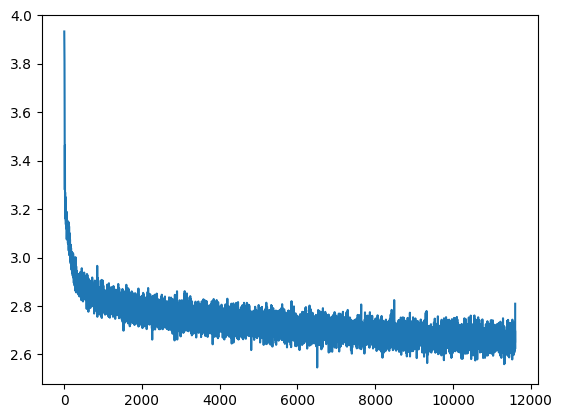

In [9]:
np.random.seed(123)
torch.random.manual_seed(123)
device = torch.device("cuda")
# device = torch.device("cpu")  # If no GPU on the machine

# train_id = np.random.choice(len(dat), 10000)
# train = [dat[i] for i in train_id]
train = dat

n = len(train)
n_hidden = 256
nepoch = 41
bs = 256

rnn = RNN(charset_size, n_hidden)
rnn = rnn.to(device=device)
opt = torch.optim.Adam(rnn.parameters(), lr=0.001)
train_ind = np.arange(n)
lossfn = nn.NLLLoss(reduction="none")
losses = []

t1 = time.time()
for k in range(nepoch):
    np.random.shuffle(train_ind)
    # Update on mini-batches
    for j in range(0, n, bs):
        # Create mini-batch
        ind = train_ind[j:(j + bs)]
        mb = [train[i] for i in ind]
        mb_size = len(mb)
        input, actual_len, target = names2tensor(mb)  # input是[max_名字长度×名字数量(bs)×charset_size]的三维tensor  actual_len是[bs]的一维 target是[max_名字长度×名字数量(bs)]的二维tensor  
        input = input.to(device=device)
        target = target.to(device=device)
        max_len = input.shape[0]
        hidden = rnn.init_hidden(mb_size).to(device=device)    # 每个名字都是一个序列 需要initial一个hidden
        loss = 0.0
        for s in range(max_len):    # 对每个时点（每个名字按顺序的索引）进行loss的计算
            output, hidden = rnn(input[s], hidden)    # output是[名字数量(bs)×charset_size]的二维tensor hidden是[名字数量(bs)×n_hidden]的二维tensor
            loss_s = lossfn(output, target[s])     # target[s]是[名字数量(bs)]的一维tensor  计算出来的loss_s也是[名字数量(bs)]的一维tensor
            valid = torch.tensor((s < actual_len).astype(int)).to(device=device)  # 把真实长度小于时点s的损失函数屏蔽
            loss = loss + loss_s * valid      # 将s个时点的[名字数量(bs)]loss相加
        loss = torch.mean(loss / torch.tensor(actual_len).to(device=device)) # 先对每个名字的loss取平均 最后取bs个名字的平均 得到一个bs的loss

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if j // bs % 10 == 0:
            print(f"epoch {k}, batch {j // bs}, loss = {loss.item()}")
t2 = time.time()
print(t2 - t1)
plt.plot(losses)

In [10]:
torch.save(rnn.state_dict(), "gen_en.pt")
rnn.load_state_dict(torch.load("gen_en.pt", map_location=device))
rnn.eval()

RNN(
  (i2h): Linear(in_features=307, out_features=256, bias=True)
  (i2o): Linear(in_features=307, out_features=51, bias=True)
  (o2o): Linear(in_features=307, out_features=51, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
)

In [11]:
family_names = np.unique([name[0] for name in dat])
def random_family_name():
    return np.random.choice(family_names, 1)[0]  # 在name的名字中抽一个名字的第一个字

def random_name(max_len=4):
    rnn.eval()
    family_name = random_family_name()      # 根据抽中的第一个字生成一个名字，名字长度不超过max_len
    input = char2tensor(family_name).to(device=device)
    char_ind = [torch.argmax(input).item()]
    hidden = rnn.init_hidden(batch_size=1).to(device=device)
    for i in range(max_len - 1):
        output, hidden = rnn(input, hidden)
        ind = torch.argmax(output).item()
        if ind == charset_size - 1:
            break
        char_ind.append(ind)
        input.zero_()
        input[0, ind] = 1.0
    return char_ind

np.random.seed(123)
torch.random.manual_seed(123)
ind = random_name(10)
print("".join([dict[i] for i in ind]))

雷斯塔


In [12]:
np.random.seed(123)
torch.random.manual_seed(123)
names = []
for i in range(50):
    ind = random_name(10)
    names.append("".join([dict[i] for i in ind]))
np.set_printoptions(linewidth=50)
print(np.array(names))

['雷斯塔' '伊斯特拉' '瓦尔德' '耶尔维' '西尔韦斯特罗' '布拉伊尼' '库尔蒂耶'
 '迪亚科' '拉斯特里' '罗斯塔' '维尔斯' '马尔基奥' '埃斯特拉' '维尔斯'
 '韦尔尼亚尼' '维尔斯' '马尔基奥' '格拉迪尼' '库尔蒂耶' '尔科' '萨尔瓦尼'
 '维尔斯' '巴尔巴里尼' '内格雷尔' '克拉斯尼' '伊斯特拉' '德拉斯特' '诺尔贝'
 '伊斯特拉' '德拉斯特' '马尔基奥' '勒布' '达尔贝' '莱斯特雷' '瓦尔德'
 '西尔韦斯特罗' '罗斯塔' '托尔托拉' '米拉尔迪' '特里亚尼' '耶尔维' '罗斯塔'
 '奇卡' '贝尔托拉' '克拉斯尼' '迪亚科' '利亚诺' '亚尔马' '塔尔迪' '耶尔维']


## 📌 核心逻辑解释

![LSTM](LSTM.jpg)


LSTM 的基本计算逻辑就是：

$$
\begin{aligned}
i_t &= \sigma(W_{ii}x_t + W_{hi}h_{t-1} + b_i) &\text{（输入门）} \\
f_t &= \sigma(W_{if}x_t + W_{hf}h_{t-1} + b_f) &\text{（遗忘门）} \\
g_t &= \tanh(W_{ig}x_t + W_{hg}h_{t-1} + b_g) &\text{（候选更新）} \\
o_t &= \sigma(W_{io}x_t + W_{ho}h_{t-1} + b_o) &\text{（输出门）} \\
c_t &= f_t \cdot c_{t-1} + i_t \cdot g_t &\text{（细胞状态）} \\
h_t &= o_t \cdot \tanh(c_t) &\text{（隐藏状态）}
\end{aligned}
$$

* 你看到我就是完整手动实现了这些计算；
* 只用到了最基本的矩阵乘法 `@` 和激活函数 `sigmoid`、`tanh`；
* 没有使用 `nn.LSTM`，控制力更强，更适合教学和理解模型底层逻辑。

## 参考版本
```python
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, input_size)
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # input shape: (batch_size=1, input_size)
        # LSTM expects input shape: (seq_len=1, batch_size, input_size)
        input = input.unsqueeze(0)  # -> (1, 1, input_size)
        output, hidden = self.lstm(input, hidden)
        output = self.fc(output.squeeze(0))  # squeeze seq_len dim
        output = self.dropout(output)
        output = self.logsoftmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        # LSTM has (h_0, c_0)
        h_0 = torch.zeros(1, batch_size, self.hidden_size)
        c_0 = torch.zeros(1, batch_size, self.hidden_size)
        return (h_0, c_0)
```

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # 四个门的线性层
        self.i2f = nn.Linear(input_size + hidden_size, hidden_size)  # forget gate
        self.i2i = nn.Linear(input_size + hidden_size, hidden_size)  # input gate
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size)  # output gate
        self.i2g = nn.Linear(input_size + hidden_size, hidden_size)  # candidate gate

        self.out_layer = nn.Linear(hidden_size, input_size)
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden  # 分别是上一个时间步的 h 和 c
        
        # 拼接输入与上一隐藏状态
        combined = torch.cat((input, h_prev), dim=1)
        
        # 四个门的计算
        f_t = torch.sigmoid(self.i2f(combined))
        i_t = torch.sigmoid(self.i2i(combined))
        o_t = torch.sigmoid(self.i2o(combined))
        g_t = torch.tanh(self.i2g(combined))
        
        # 细胞状态更新
        c_t = f_t * c_prev + i_t * g_t
        
        # 隐藏状态更新
        h_t = o_t * torch.tanh(c_t)
        
        # 输出层
        output = self.out_layer(h_t)
        output = self.dropout(output)
        output = self.logsoftmax(output)
        
        return output, (h_t, c_t)

    def init_hidden(self, batch_size):
        # 初始化隐藏状态和细胞状态
        return (torch.zeros(batch_size, self.hidden_size),
                torch.zeros(batch_size, self.hidden_size))


In [14]:
n_hidden = 64
lstm = MyLSTM(charset_size, n_hidden)
lstm = lstm

input = name2tensor("斯基")  # one-hot tensor: (seq_len, 1, charset_size)

hidden = lstm.init_hidden(batch_size=1)
# 如果你在GPU上训练，需要将 hidden 的每个部分也迁移到 device：
hidden = (hidden[0], hidden[1])

output, next_hidden = lstm(input[0], hidden)  # 取第一个字符
print(output.shape)  # 应为 (1, charset_size)
print(output)


torch.Size([1, 51])
tensor([[-3.7980, -3.9237, -3.9574, -3.9989, -3.9022, -3.9993, -3.8726, -3.8635,
         -4.0193, -3.8123, -3.9237, -3.9228, -4.0291, -4.0072, -3.7832, -3.9680,
         -3.9796, -4.0067, -3.8826, -3.9180, -3.9001, -3.7777, -3.9703, -3.9432,
         -4.0576, -3.9843, -3.8746, -3.9716, -3.9237, -3.9719, -3.9655, -3.8045,
         -4.0346, -3.9110, -3.9006, -3.9237, -3.9821, -3.8808, -3.9879, -3.8092,
         -4.0674, -3.9435, -3.8847, -4.0273, -3.8630, -4.0622, -3.9579, -3.8586,
         -3.9088, -3.9071, -4.0414]], grad_fn=<LogSoftmaxBackward0>)


epoch 0, batch 0, loss = 3.920159339904785
epoch 0, batch 10, loss = 3.8167285919189453
epoch 0, batch 20, loss = 3.3907968997955322
epoch 0, batch 30, loss = 3.292941093444824
epoch 0, batch 40, loss = 3.2086362838745117
epoch 0, batch 50, loss = 3.1812734603881836
epoch 0, batch 60, loss = 3.1704182624816895
epoch 0, batch 70, loss = 3.177886962890625
epoch 0, batch 80, loss = 3.177851676940918
epoch 0, batch 90, loss = 3.146270751953125
epoch 0, batch 100, loss = 3.139838695526123
epoch 0, batch 110, loss = 3.1474618911743164
epoch 0, batch 120, loss = 3.1421828269958496
epoch 0, batch 130, loss = 3.080841064453125
epoch 0, batch 140, loss = 3.1141881942749023
epoch 0, batch 150, loss = 3.097585916519165
epoch 0, batch 160, loss = 3.126110792160034
epoch 0, batch 170, loss = 3.1021790504455566
epoch 0, batch 180, loss = 3.0965919494628906
epoch 0, batch 190, loss = 3.0928590297698975
epoch 0, batch 200, loss = 3.052140712738037
epoch 0, batch 210, loss = 3.052572250366211
epoch 0, b

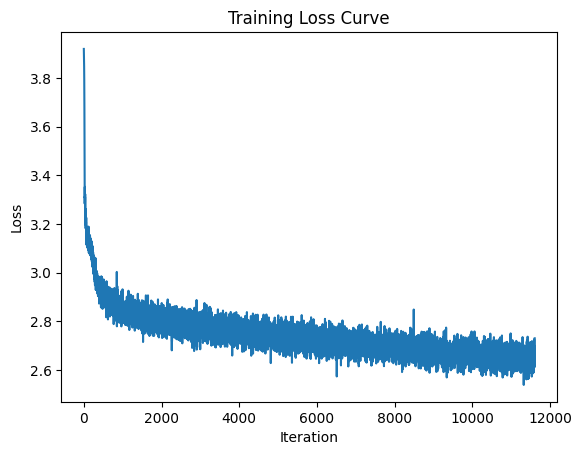

In [15]:
np.random.seed(123)
torch.random.manual_seed(123)

device = torch.device("cuda")  # 或者 "cpu"

train = dat  # 你的训练数据
n = len(train)
n_hidden = 256
nepoch = 41
bs = 256

lstm = MyLSTM(charset_size, n_hidden).to(device)
opt = torch.optim.Adam(lstm.parameters(), lr=0.001)
lossfn = nn.NLLLoss(reduction="none")

train_ind = np.arange(n)
losses = []

t1 = time.time()
for k in range(nepoch):
    np.random.shuffle(train_ind)
    for j in range(0, n, bs):
        ind = train_ind[j:(j + bs)]
        mb = [train[i] for i in ind]
        mb_size = len(mb)
        input, actual_len, target = names2tensor(mb)
        input = input.to(device)
        target = target.to(device)

        max_len = input.shape[0]
        hidden = lstm.init_hidden(mb_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))

        loss = 0.0
        for s in range(max_len):
            output, hidden = lstm(input[s], hidden)
            loss_s = lossfn(output, target[s])
            valid = torch.tensor((s < actual_len).astype(int)).to(device)
            loss = loss + loss_s * valid
        loss = torch.mean(loss / torch.tensor(actual_len).to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if (j // bs) % 10 == 0:
            print(f"epoch {k}, batch {j // bs}, loss = {loss.item()}")
t2 = time.time()
print("Training time:", t2 - t1)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


In [16]:
# 保存模型参数
torch.save(lstm.state_dict(), "gen_en_lstm.pt")

# 加载模型参数
lstm.load_state_dict(torch.load("gen_en_lstm.pt", map_location=device))

# 设置模型为评估模式
lstm.eval()


MyLSTM(
  (i2f): Linear(in_features=307, out_features=256, bias=True)
  (i2i): Linear(in_features=307, out_features=256, bias=True)
  (i2o): Linear(in_features=307, out_features=256, bias=True)
  (i2g): Linear(in_features=307, out_features=256, bias=True)
  (out_layer): Linear(in_features=256, out_features=51, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
)

In [17]:
def random_name_lstm(max_len=4):
    lstm.eval()
    family_name = random_family_name()
    input = char2tensor(family_name).to(device)
    char_ind = [torch.argmax(input).item()]
    hidden = lstm.init_hidden(batch_size=1)
    hidden = (hidden[0].to(device), hidden[1].to(device))

    for _ in range(max_len - 1):
        output, hidden = lstm(input, hidden)
        ind = torch.argmax(output).item()
        if ind == charset_size - 1:  # <END>
            break
        char_ind.append(ind)
        input.zero_()
        input[0, ind] = 1.0
    return char_ind


In [18]:
np.random.seed(123)
torch.manual_seed(123)

names = []
for i in range(50):
    ind = random_name_lstm(max_len=10)
    names.append("".join([dict[i] for i in ind]))

np.set_printoptions(linewidth=50)
print(np.array(names))


['雷斯塔尼奥' '伊尔贝' '瓦尔德拉' '耶尔维' '西尔韦斯特里' '布拉西尼' '库尔蒂'
 '迪亚科' '拉斯特里' '罗斯塔' '维尔德' '马尔科利尼' '埃斯特拉蒂耶' '维尔德'
 '韦尔纳' '维尔德' '马尔科利尼' '格拉迪斯拉夫' '库尔蒂' '尔科' '萨尔瓦尼'
 '维尔德' '巴尔达奇' '内斯特' '克拉斯特' '伊尔贝' '德拉斯特' '诺尔贝'
 '伊尔贝' '德拉斯特' '马尔科利尼' '勒夫' '达尔贝' '莱斯特拉' '瓦尔德拉'
 '西尔韦斯特里' '罗斯塔' '托尔托拉' '米尔科夫斯基' '特里亚诺' '耶尔维'
 '罗斯塔' '奇科尼' '贝尔托利' '克拉斯特' '迪亚科' '利亚诺' '亚尔马'
 '塔尔塔' '耶尔维']
